In [1]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.0 MB/s eta 0:00:00
Mounted at /content/gdrive


In [2]:
def get_data(url, presize, resize):
    path = untar_data(url)
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock), get_items=get_image_files,
        splitter=GrandparentSplitter(valid_name='val'),
        get_y=parent_label, item_tfms=Resize(presize),
        batch_tfms=[*aug_transforms(min_scale=0.5, size=resize),
                    Normalize.from_stats(*imagenet_stats)],
    ).dataloaders(path, bs=128)

dls = get_data(URLs.IMAGENETTE_160, 160, 128)

In [3]:
def get_learner(**kwargs):
    return vision_learner(dls, resnet34, pretrained=False,
                    metrics=accuracy, **kwargs).to_fp16()

In [4]:
# 使用fastai默认的优化器
learn = get_learner()
learn.fit_one_cycle(3, 0.003)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [5]:
learn = get_learner(opt_func=SGD)

SuggestedLRs(valley=0.005248074419796467)

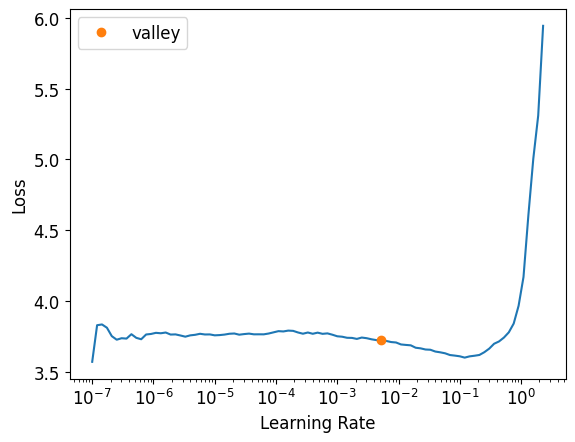

In [6]:
learn.lr_find()

In [7]:
# fastai默认引用动量, 关闭它
learn.fit_one_cycle(3, 0.03, moms=(0,0,0))

In [10]:
# 从0创建优化器
def sgd_cb(p, lr, **kwargs): p.data.add_(p.grad.data, alpha=-lr)
opt_func = partial(Optimizer, cbs=[sgd_cb])

In [11]:
learn = get_learner(opt_func=opt_func)
learn.fit(3, 0.03)

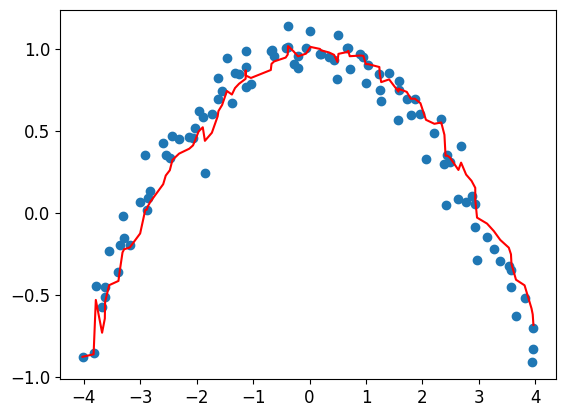

In [36]:
x = np.linspace(-4, 4, 100)
y = 1 - (x/3) ** 2
x1 = x + np.random.randn(100) * 0.1
y1 = y + np.random.randn(100) * 0.1
plt.scatter(x1,y1)
idx = x1.argsort()
beta,avg,res = 0.7,0,[]
for i in idx:
    avg = beta * avg + (1-beta) * y1[i]
    res.append(avg/(1-beta**(i+1)))
plt.plot(x1[idx],np.array(res), color='red');

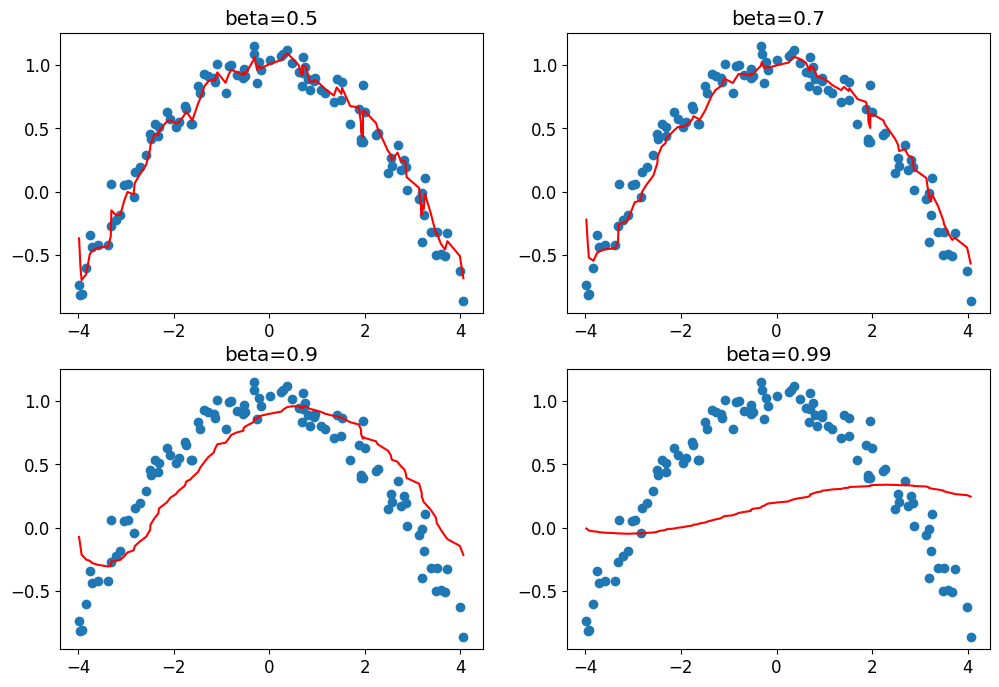

In [43]:
x = np.linspace(-4, 4, 100)
y = 1 - (x/3) ** 2
x1 = x + np.random.randn(100) * 0.1
y1 = y + np.random.randn(100) * 0.1
_,axs = plt.subplots(2,2, figsize=(12,8))
betas = [0.5,0.7,0.9,0.99]
idx = x1.argsort()
for beta,ax in zip(betas, axs.flatten()):
    ax.scatter(x1,y1)
    avg,res = 0,[]
    for i in idx:
        avg = beta * avg + (1-beta) * y1[i]
        res.append(avg)#/(1-beta**(i+1)))
    ax.plot(x1[idx],np.array(res), color='red');
    ax.set_title(f'beta={beta}')

In [37]:
def average_grad(p, mom, grad_avg=None, **kwargs):
    if grad_avg is None: grad_avg = torch.zeros_like(p.grad.data)
    return {'grad_avg': grad_avg*mom + p.grad.data}

In [39]:
def momentum_step(p, lr, grad_avg, **kwargs): p.data.add_(-lr, grad_avg)

In [40]:
opt_func = partial(Optimizer, cbs=[average_grad,momentum_step], mom=0.9)

In [41]:
learn = get_learner(opt_func=opt_func)
learn.fit_one_cycle(3, 0.03)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


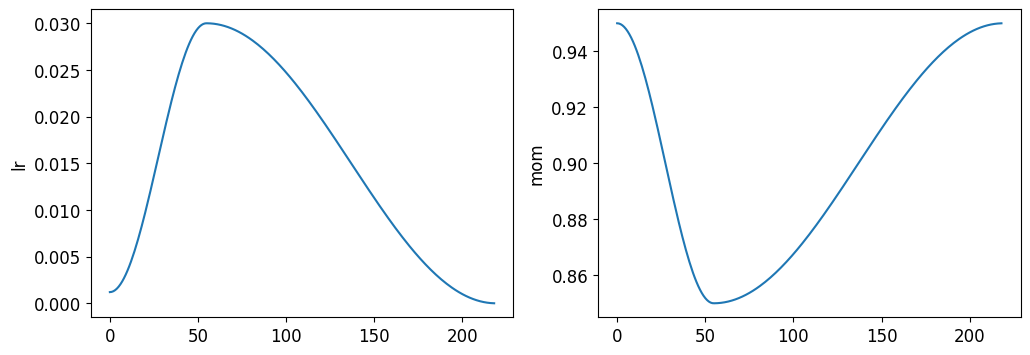

In [42]:
learn.recorder.plot_sched()

In [45]:
def average_sqr_grad(p, sqr_mom, sqr_avg=None, **kwargs):
    if sqr_avg is None: sqr_avg = torch.zeros_like(p.grad.data)
    return {'sqr_avg': sqr_mom*sqr_avg + (1-sqr_mom)*p.grad.data**2}

def rms_prop_step(p, lr, sqr_avg, eps, grad_avg=None, **kwargs):
    denom = sqr_avg.sqrt().add_(eps)
    p.data.addcdiv_(-lr, p.grad, denom) #p.data = p.data - lr * p.grad / denom

opt_func = partial(Optimizer, cbs=[average_sqr_grad,rms_prop_step],
                   sqr_mom=0.99, eps=1e-7)

In [46]:
learn = get_learner(opt_func=opt_func)
learn.fit_one_cycle(3, 0.003)

In [59]:
# 一阶矩估计
def average_grad(p, mom, grad_avg=None, **kwargs):
    if grad_avg is None:
        grad_avg = torch.zeros_like(p.grad.data)
    return {'grad_avg': grad_avg*mom + (1-mom)*p.grad.data}

# 二阶矩估计
def average_sqr_grad(p, sqr_mom, sqr_avg=None, **kwargs):
    if sqr_avg is None:
        sqr_avg = torch.zeros_like(p.grad.data)
    return {'sqr_avg': sqr_mom*sqr_avg + (1-sqr_mom)*p.grad.data**2}

# Adam 更新步骤
def adam_step(p, lr, grad_avg, sqr_avg, eps, step, mom, sqr_mom, **kwargs):
    # 对一阶矩和二阶矩进行偏差校正
    corrected_grad_avg = grad_avg / (1 - mom**step)
    corrected_sqr_avg = sqr_avg / (1 - sqr_mom**step)
    denom = corrected_sqr_avg.sqrt().add_(eps)
    p.data.addcdiv_(-lr, corrected_grad_avg, denom)
    step +=1

# 定义优化器
opt_func = partial(Optimizer, cbs=[average_grad, average_sqr_grad, adam_step], mom=0.9, sqr_mom=0.99, eps=1e-8, step=1)


In [60]:
learn = get_learner(opt_func=opt_func)
learn.fit_one_cycle(3, 0.003)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
